In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots

In [2]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
input_dir = "./InputData/"
output_dir = "./OutputData/"

## Data prep

In [4]:
# Load data, convert "time" to datetime format, add deficit column
df = pd.read_csv(output_dir + "full_data.csv")
df["time"] = pd.to_datetime(df["time"], format = "%d:%m:%Y:%H:%M")
df["deficit"] = df["consumption_MWh"] - df["total_generation_MWh"]

In [5]:
df

,time,consumption_MWh,total_generation_MWh,natural_gas,hydro_dam,lignite,hydro_river,coal_imported,wind,solar,...,hard_coal,biomass,naphtha,LNG,international,waste_heat,TRY/MWh,USD/MWh,EUR/MWh,deficit
0,2018-01-01 00:00:00,27412.81,27412.81,6926.78,4820.40,5226.32,1900.32,5314.05,1179.51,0.0,...,189.50,210.96,0.0,0.0,297.00,92.08,207.60,55.04,45.97,0.00
1,2018-01-01 01:00:00,26324.39,26324.39,6603.44,3644.32,5277.19,1877.83,5715.61,1148.46,0.0,...,205.50,211.67,0.0,0.0,287.00,91.14,205.34,54.44,45.47,0.00
2,2018-01-01 02:00:00,24635.32,24635.32,6040.77,2711.00,5325.47,1708.49,5701.37,1216.38,0.0,...,201.50,209.89,0.0,0.0,169.00,91.06,164.94,43.73,36.53,0.00
3,2018-01-01 03:00:00,23872.12,23872.12,5938.46,2524.37,5265.91,1662.59,5205.43,1298.11,0.0,...,211.50,211.24,0.0,0.0,214.00,91.83,154.52,40.97,34.22,0.00
4,2018-01-01 04:00:00,23194.89,23194.89,5665.41,2462.71,5282.88,1697.96,4804.19,1220.91,0.0,...,307.50,214.31,0.0,0.0,203.00,91.23,112.64,29.86,24.95,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2023-12-31 19:00:00,35090.93,34753.40,5567.82,8719.86,5311.18,2287.36,9100.92,359.70,0.0,...,613.05,997.70,0.0,0.0,270.20,82.49,2499.67,84.91,76.74,337.53
52580,2023-12-31 20:00:00,33310.94,31441.31,4792.96,7881.64,4908.48,2083.33,7613.93,459.87,0.0,...,612.95,983.26,0.0,0.0,539.84,85.01,2472.34,83.98,75.90,1869.63
52581,2023-12-31 21:00:00,32083.96,30368.98,4000.94,7513.96,4911.94,1966.32,7656.56,552.62,0.0,...,607.59,977.02,0.0,0.0,629.91,84.63,2472.33,83.98,75.90,1714.98
52582,2023-12-31 22:00:00,30469.49,30386.41,2903.52,8119.63,4615.93,1837.75,8390.47,720.11,0.0,...,608.31,987.47,0.0,0.0,627.77,83.35,1800.00,61.15,55.26,83.08


In [6]:
# Aggregate by day
df_daily = df.copy().set_index("time")
agg_funcs = ("sum " * 18).split(" ")[0:-1]
agg_funcs = agg_funcs + ["mean", "mean", "mean", "sum"]
agg_cols = dict(zip(df_daily.columns.values, agg_funcs))
df_daily = df_daily.groupby(df_daily.index.date).aggregate(agg_cols).reset_index(names = "time")

In [7]:
df_daily

,time,consumption_MWh,total_generation_MWh,natural_gas,hydro_dam,lignite,hydro_river,coal_imported,wind,solar,...,hard_coal,biomass,naphtha,LNG,international,waste_heat,TRY/MWh,USD/MWh,EUR/MWh,deficit
0,2018-01-01,672127.68,672127.68,205081.00,83771.12,121224.96,46900.08,134299.83,31365.10,23.36,...,7961.50,5228.04,0.0,24.17,5311.40,2144.96,161.041667,42.695417,35.664583,0.00
1,2018-01-02,811275.64,811275.64,308838.32,79695.24,119643.01,43806.76,152959.50,61325.11,61.47,...,8503.00,5749.52,0.0,20.19,-1522.00,2063.01,175.875833,46.627917,38.949167,0.00
2,2018-01-03,851617.52,851617.52,333147.20,82439.29,118305.31,44896.98,173464.16,56128.55,51.77,...,8436.50,5768.05,0.0,0.00,-2908.01,2125.97,173.490833,46.076667,38.235833,0.00
3,2018-01-04,863492.42,863492.42,322638.10,93175.93,122406.92,51436.68,185086.43,46931.16,26.75,...,8073.00,5576.65,0.0,22.49,-4210.55,2205.46,175.292917,46.599583,38.723333,0.00
4,2018-01-05,854542.70,854542.70,305823.09,83901.90,128787.71,54348.47,179947.70,60845.47,36.69,...,7974.00,5950.88,0.0,24.07,-5261.21,2170.48,169.443333,45.065833,37.431250,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2023-12-27,909315.54,856208.37,142398.25,190742.68,115704.89,52189.57,183787.70,68434.22,9165.28,...,14266.03,23940.91,0.0,0.00,15985.42,1786.96,2114.216667,72.378750,65.706250,53107.17
2187,2023-12-28,905605.21,853261.07,135465.07,192632.99,127101.97,49956.02,197843.77,46635.31,8861.83,...,14386.98,23979.82,0.0,0.00,16837.98,1946.87,2123.542083,72.562917,65.861250,52344.14
2188,2023-12-29,892609.49,832640.42,130462.50,183107.01,127252.58,47398.82,194948.13,42067.22,7883.39,...,14749.89,24333.89,0.0,0.00,20388.08,1996.91,2201.463750,75.037917,67.908333,59969.07
2189,2023-12-30,834855.23,781688.92,90015.98,173765.66,120931.96,45002.51,196260.36,49183.75,9110.93,...,14664.43,24033.67,0.0,0.00,19247.38,2137.30,2003.797500,68.162917,61.288750,53166.31


## Plots

### Time plots

In [8]:
def time_plot(df = df, df_daily = df_daily, variable = "consumption_MWh", horizontal_color = "crimson"):

    # Process means for horizontal lines
    mean_hourly = df[variable].mean()
    mean_daily = df_daily[variable].mean()

    # Figure
    fig, ax = plt.subplots(2)
    fig.suptitle(variable)

    # Hourly plot
    _ = sns.lineplot(
    data = df,
    x = "time",
    y = variable,
    ax = ax[0]
    )
    _ = ax[0].set_xlabel("hourly")
    _ = ax[0].axhline(y = mean_hourly, c = horizontal_color, label = "mean")
    _ = ax[0].legend()
    
    # Daily plot
    _ = sns.lineplot(
    data = df_daily,
    x = "time",
    y = variable,
    ax = ax[1]
    )
    _ = ax[1].set_xlabel("daily aggregation")
    _ = ax[1].axhline(y = mean_daily, c = horizontal_color)

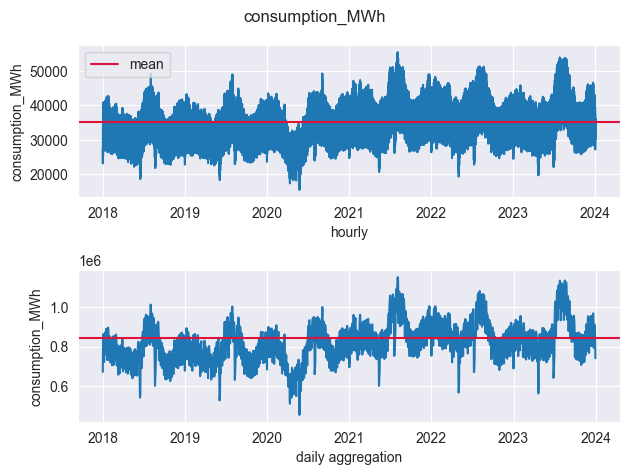

In [9]:
# Consumption
time_plot(variable = "consumption_MWh")

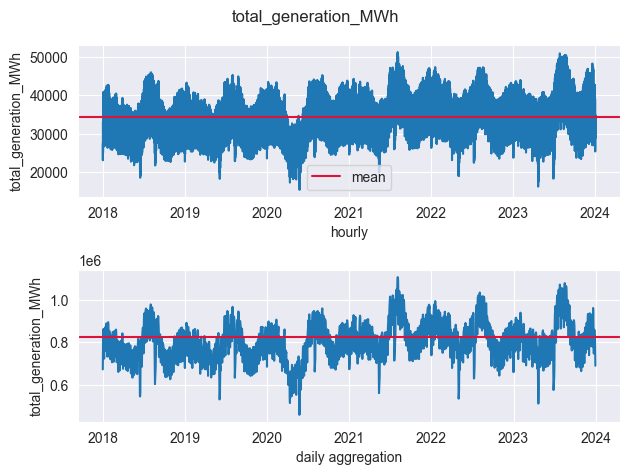

In [10]:
# Generation, total
time_plot(variable = "total_generation_MWh")

Consumption & generation shows a slight positive linear trend. Probably more steep as the historical data extends backwards.

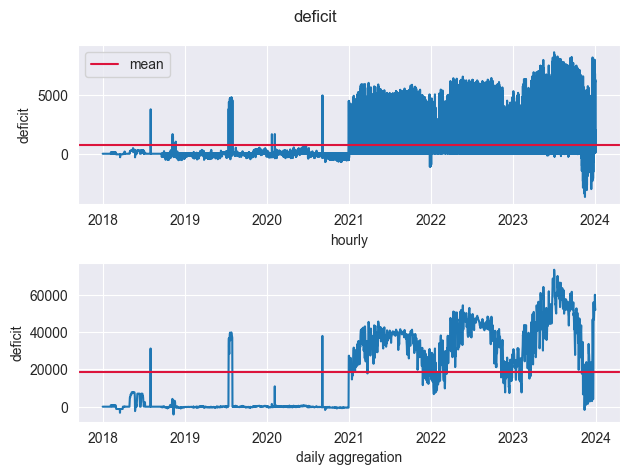

In [11]:
# Deficit
time_plot(variable = "deficit")

Deficits are mostly zero with occasional spikes before 2021, while they are large & consistent afterwards. Probably a change in data collection.

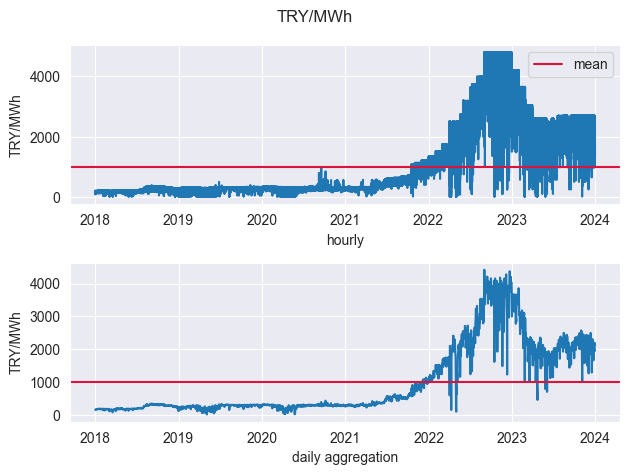

In [12]:
# Market clearing price, TRY
time_plot(variable = "TRY/MWh")

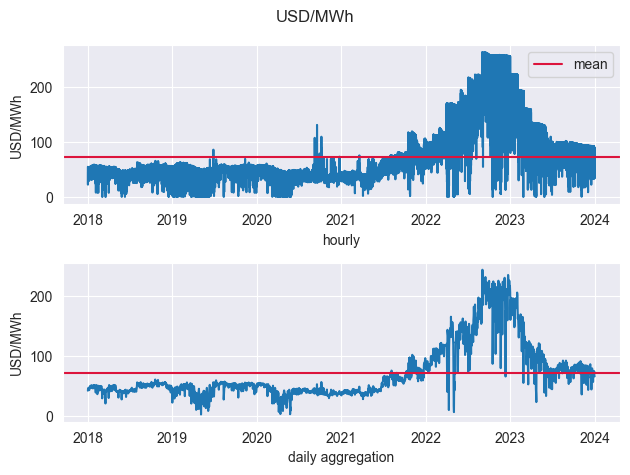

In [13]:
# Market clearing price, USD
time_plot(variable = "USD/MWh")

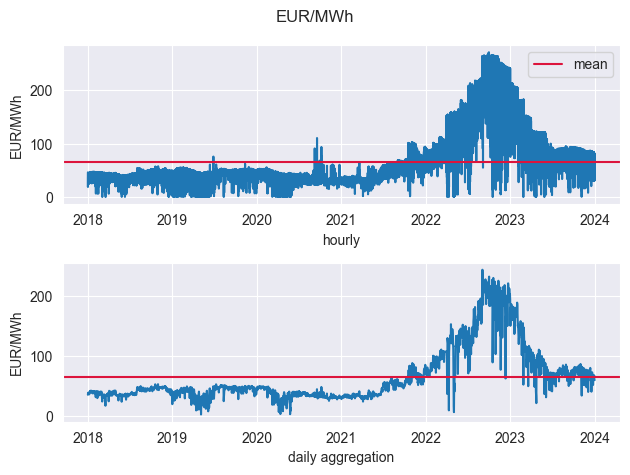

In [14]:
# Market clearing price, EUR
time_plot(variable = "EUR/MWh")

TRY is more volatile as expected. Use USD or EUR as target.

Prices ramped up exponentially after 2021, and declined exponentially from roughly fall 2022, possibly returning to a new process mean around roughly mid 2023. Likely no linear trend otherwise.

Should reflect the 2021-2023 cyclicality with some sort of covariate. Maybe a piecewise exponential that takes a value of 0 othwerise?

## Seasonal plots

In [15]:
def seasonal_plot1(df = df, variable = "consumption_MWh", groupby_year = True):

    # Grouping variable
    hue = None
    if groupby_year:
        hue = df.time.dt.year.astype(str)

    fig, ax = plt.subplots(2, 2)
    fig.suptitle("Seasonality, " + variable)

    # Hour of day
    _ = sns.lineplot(
        x = df.time.dt.hour,
        y = df[variable],
        hue = hue,
        marker = "o",
        markersize = 4,
        legend = False,
        ax = ax[0, 0]
    )
    _ = ax[0, 0].set_xticks(range(0, 25, 6))
    _ = ax[0, 0].set_xlabel("hour of day")

    # Day of week
    _ = sns.lineplot(
        x = df.time.dt.weekday,
        hue = hue,
        marker = "o",
        markersize = 4,
        legend = False,
        y = df[variable],
        ax = ax[0, 1]
    )
    _ = ax[0, 1].set_xticks(range(0, 7, 1))
    _ = ax[0, 1].set_xlabel("day of week, monday-sunday")

    # Week of year
    _ = sns.lineplot(
        x = df.time.dt.isocalendar().week,
        hue = hue,
        legend = False,
        y = df[variable],
        ax = ax[1, 0]
    )
    _ = ax[1, 0].set_xticks(range(0, 54, 8))
    _ = ax[1, 0].set_xlabel("week of year")

    # Month of year
    _ = sns.lineplot(
        x = df.time.dt.month,
        y = df[variable],
        hue = hue,
        marker = "o",
        markersize = 4,
        ax = ax[1, 1]
    )
    _ = ax[1, 1].set_xticks(range(1, 13, 1))
    _ = ax[1, 1].set_xlabel("month")

    if not groupby_year:
        return
    
    _ = ax[1, 1].legend(
            title = "year", 
            bbox_to_anchor = (1.05, 1.0), 
            fontsize = "small",
            loc = "best"
    )

In [16]:
def seasonal_plot2(df = df, variable = "consumption_MWh", groupby_month = True):

    # Grouping variable
    hue = None
    if groupby_month:
        hue = df.time.dt.month.astype(str)

    fig, ax = plt.subplots(2)
    fig.suptitle("Seasonality, " + variable)

    # Hour of day
    _ = sns.lineplot(
        x = df.time.dt.hour,
        y = df[variable],
        hue = hue,
        markers = hue,
        #marker = "o",
        markersize = 4,
        ax = ax[0]
    )
    _ = ax[0].set_xticks(range(0, 25, 6))
    _ = ax[0].set_xlabel("hour of day")

    # Day of week
    _ = sns.lineplot(
        x = df.time.dt.weekday,
        hue = hue,
        markers = hue,
        #marker = "o",
        markersize = 4,
        legend = False,
        y = df[variable],
        ax = ax[1]
    )
    _ = ax[1].set_xticks(range(0, 7, 1))
    _ = ax[1].set_xlabel("day of week, monday-sunday")

    if not groupby_month:
        return
    
    _ = ax[0].legend(
            title = "month", 
            bbox_to_anchor = (1.05, 1.0), 
            fontsize = "small",
            loc = "best"
    )

In [17]:
def seasonal_plot3(df = df, variable = "consumption_MWh"):

    hue = df.time.dt.month.astype(str)

    fig, ax = plt.subplots(2)
    fig.suptitle("Seasonality, " + variable)

    # Day of month, ungrouped
    _ = sns.lineplot(
        x = df.time.dt.day,
        y = df[variable],
        hue = None,
        marker = "o",
        markersize = 4,
        legend = False,
        ax = ax[0]
    )
    _ = ax[0].set_xticks(range(1, 32, 6))
    _ = ax[0].set_xlabel("day of month")

    # Day of month, grouped
    _ = sns.lineplot(
        x = df.time.dt.day,
        y = df[variable],
        hue = hue,
        ax = ax[1]
    )
    _ = ax[1].set_xticks(range(1, 32, 6))
    _ = ax[1].set_xlabel("day of month")

    _ = ax[1].legend(
            title = "month", 
            bbox_to_anchor = (1.05, 1.0), 
            fontsize = "small",
            loc = "best"
    )

### Consumption

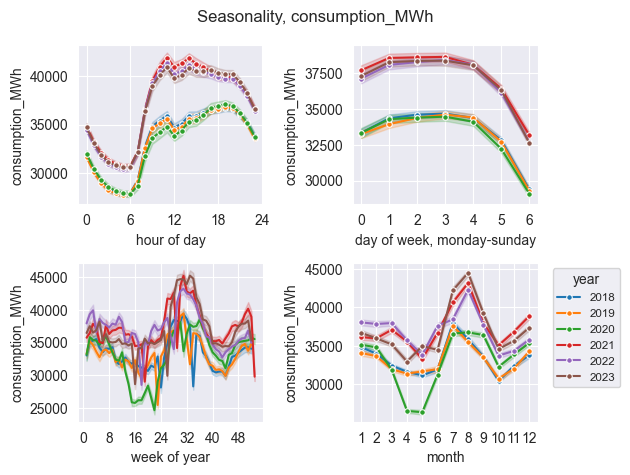

In [18]:
# Consumption seasonality, by year
seasonal_plot1(
    variable = "consumption_MWh",
    groupby_year = True
)

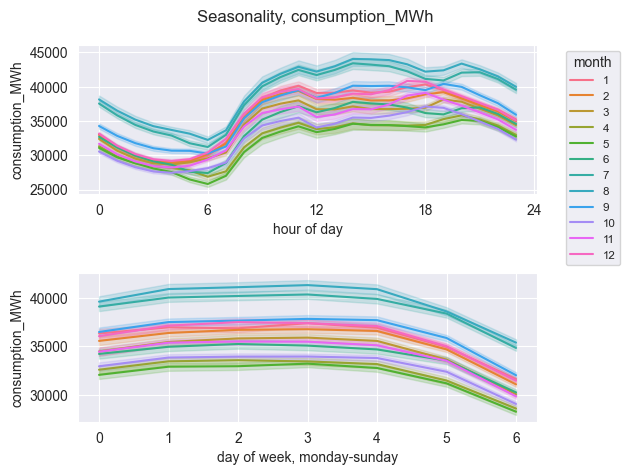

In [19]:
# Consumption seasonality, by month
seasonal_plot2(
    variable = "consumption_MWh",
    groupby_month = True
)

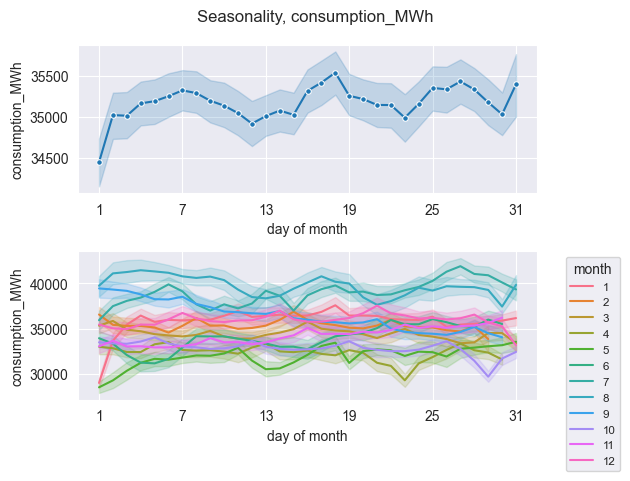

In [20]:
# Consumption day of month seasonality, by month
seasonal_plot3(variable = "consumption_MWh")

### Deficit

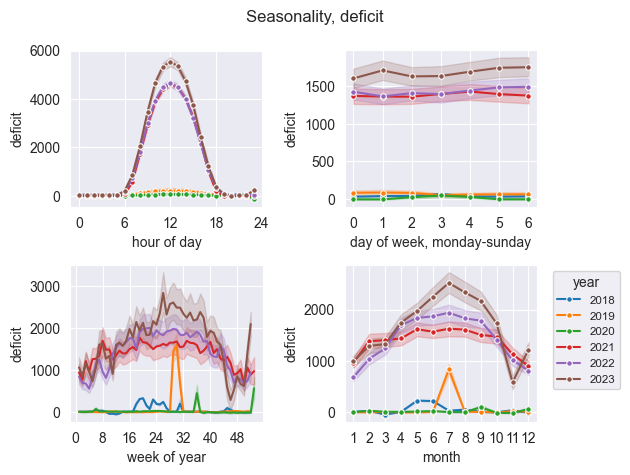

In [21]:
# Deficit seasonality, by year
seasonal_plot1(
    variable = "deficit",
    groupby_year = True
)

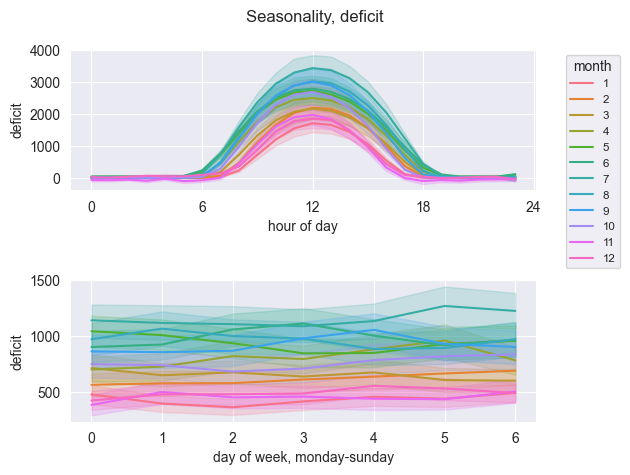

In [22]:
# Deficit seasonality, by month
seasonal_plot2(
    variable = "deficit",
    groupby_month = True
)

Deficits very dependably ramp from 6am to 12 am, decline to 18pm. Sometimes they happen around 12am. They ramp towards the summer and decline afterwards.

### Price USD

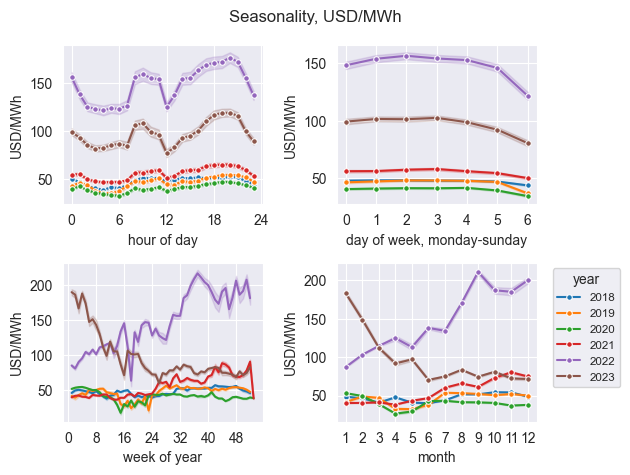

In [24]:
# Price seasonality, by year
seasonal_plot1(
    variable = "USD/MWh",
    groupby_year = True
)

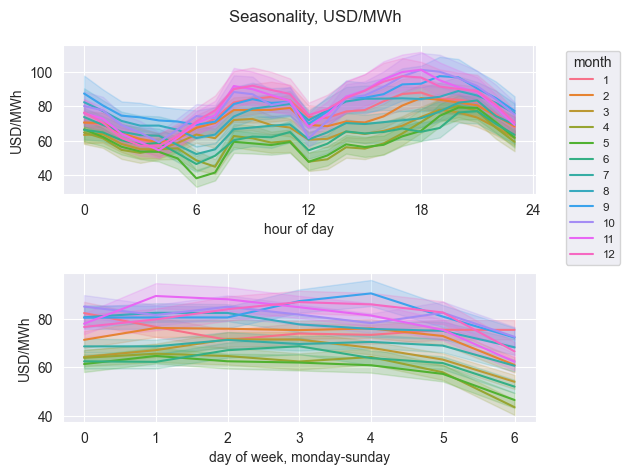

In [26]:
# Price seasonality, by month
seasonal_plot2(
    variable = "USD/MWh",
    groupby_month = True
)

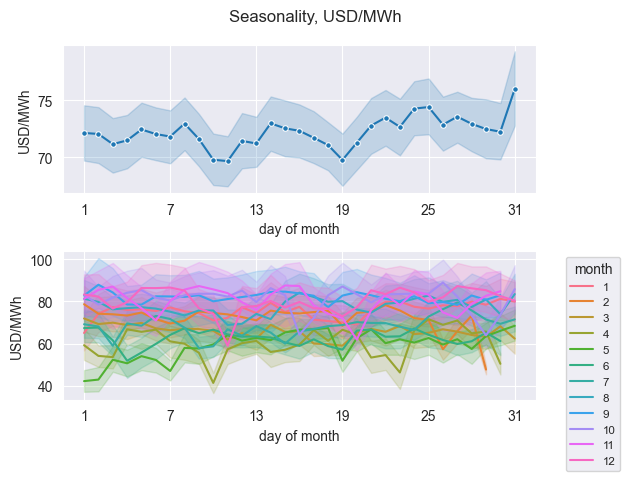

In [27]:
# Price day of month seasonality, by month
seasonal_plot3(variable = "USD/MWh")

Seasonality features to use: Day of hour, day of week. Possibly month, but hard to tell.

## Autocorrelation plots

In [38]:
def plot_autocorrelation(data = df, data_daily = df_daily, variable = "USD/MWh", lags_hourly = 48, lags_daily = 30):

    fig, ax = plt.subplots(2, 2)

    # Autocorrelation, hourly
    tsaplots.plot_acf(
        ax = ax[0, 0],
        x = df[variable],
        lags = lags_hourly,
        title = "ACF hourly, " + variable
    )

    # Partial autocorrelation, hourly
    tsaplots.plot_pacf(
        ax = ax[1, 0],
        x = df[variable],
        lags = lags_hourly,
        title = "PACF hourly, " + variable
    )

    # Autocorrelation, daily
    tsaplots.plot_acf(
        ax = ax[0, 1],
        x = df[variable],
        lags = lags_daily,
        title = "ACF daily, " + variable
    )

    # Partial autocorrelation, daily
    tsaplots.plot_pacf(
        ax = ax[1, 1],
        x = df[variable],
        lags = lags_daily,
        title = "PACF daily, " + variable
    )
    

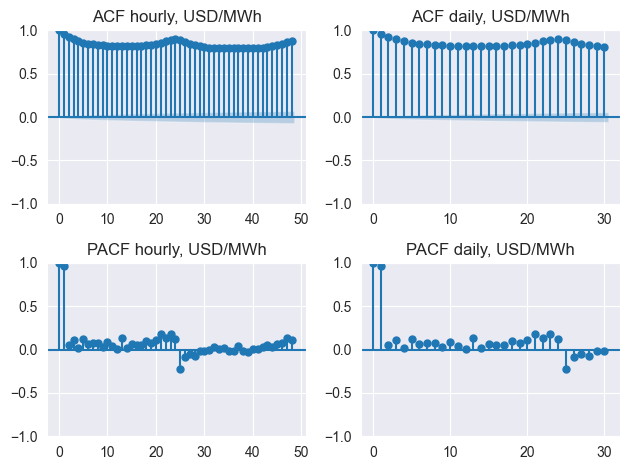

In [39]:
# Price
plot_autocorrelation()

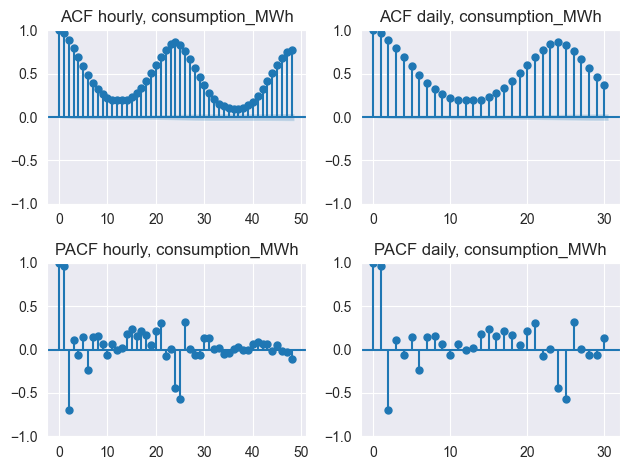

In [40]:
# Consumption
plot_autocorrelation(variable = "consumption_MWh")

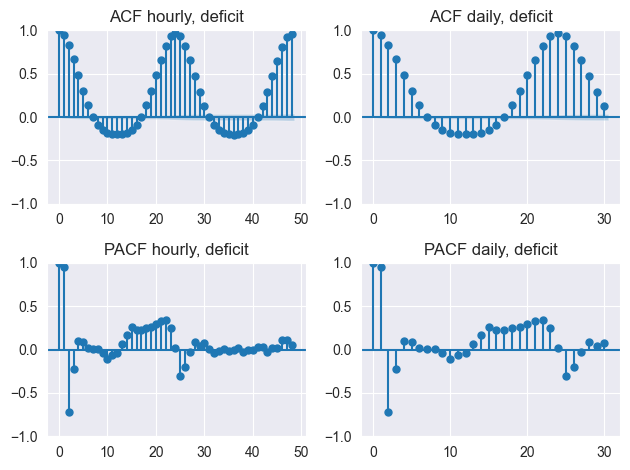

In [41]:
# Deficit
plot_autocorrelation(variable = "deficit")